### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [52]:
import ads
import io
import os
import tempfile
import uuid
import logging
import pandas as pd
import json

from ads.common import auth as authutil
from ads.dataflow.dataflow import DataFlow
from ads.dataset.factory import DatasetFactory
from ads.model.framework.automl_model import AutoMLModel
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.model.deployment import ModelDeployer, ModelDeploymentProperties
from os import path

In [2]:
ads.set_auth(auth="resource_principal")

In [3]:
#crianção de diretorio temporário
dataflow_base_folder = tempfile.mkdtemp()

In [4]:
#criando estrutura de autenticação no dataflow
data_flow = DataFlow(dataflow_base_folder=dataflow_base_folder, 
                     os_auth=authutil.resource_principal({"timeout": 60000}), 
                     df_auth=authutil.resource_principal({"timeout": 60000}))
print("Data flow directory: {}".format(dataflow_base_folder))

  after removing the cwd from sys.path.

Data flow directory: /tmp/tmph7cbrjer


In [5]:
#geração de script pyspark
pyspark_file_path = path.join(dataflow_base_folder, "hospedagem_berlim-{}.py".format(str(uuid.uuid4())[-6:]))
script = '''
from pyspark.sql import SparkSession

def main():
    
    # Create a Spark session
    spark = SparkSession \\
        .builder \\
        .appName("Python Spark SQL basic example") \\
        .getOrCreate()
    
    # Load a csv file from dataflow public storage
    df = spark \\
        .read \\
        .format("csv") \\
        .option("header", "true") \\
        .option("multiLine", "true") \\
        .load("oci://oow_2019_dataflow_lab@bigdatadatasciencelarge/usercontent/kaggle_berlin_airbnb_listings_summary.csv")
    
    # Create a temp view and do some SQL operations
    df.createOrReplaceTempView("berlin")
    query_result_df = spark.sql("""
        SELECT 
            city,  
            zipcode,  
            CONCAT(latitude,',', longitude) AS lat_long,
            neighbourhood,
            bathrooms,
            bedrooms,
            price
        FROM berlin 
    """)
    
    # Convert the filtered Apache Spark DataFrame into JSON format
    # Note: we are writing to the spark stdout log so that we can retrieve the log later at the end of the notebook.
    print('\\n'.join(query_result_df.toJSON().collect()))
    
if __name__ == '__main__':
    main()
'''

with open(pyspark_file_path, 'w') as f:
    print(script.strip(), file=f)
    
print("Script path: {}".format(pyspark_file_path))

Script path: /tmp/tmph7cbrjer/hospedagem_berlim-d43a72.py


In [6]:
#carga do script no buckt e criação da configuração aplicação do Dataflow
script_bucket = "dataflow-warehousing"        # Update the value
logs_bucket = "data-flow"               # Update the value
display_name = "App_Consolidacao_Berlim"

app_config = data_flow.prepare_app(display_name = 'App Consolidacao Berlim',
                                   script_bucket=script_bucket,
                                   pyspark_file_path=pyspark_file_path,
                                   logs_bucket=logs_bucket,
                                   driver_shape = 'VM.Standard2.1',
                                   executor_shape = 'VM.Standard2.1',
                                   num_executors = 2,
                                   spark_version = '3.2.1'
                                  )

In [7]:
#publicação do aplicativo pyspark no Dataflow
app = data_flow.create_app(app_config, overwrite_script = True, overwrite_archive = True)
app.config

loop1:   0%|          | 0/2 [00:00<?, ?it/s]

{'compartment_id': 'ocid1.compartment.oc1..aaaaaaaaaoadl3zx37kdrpne3ikdikof247ovstjpti76gzhdnccee6lxrsa',
 'language': 'PYTHON',
 'pyspark_file_path': '/tmp/tmph7cbrjer/hospedagem_berlim-d43a72.py',
 'script_bucket': 'dataflow-warehousing',
 'archive_path': None,
 'archive_bucket': None,
 'logs_bucket': 'data-flow',
 'display_name': 'App Consolidacao Berlim',
 'driver_shape': 'VM.Standard2.1',
 'executor_shape': 'VM.Standard2.1',
 'num_executors': 2,
 'spark_version': '3.2.1'}

In [8]:
#link de acesso à aplicação
app.oci_link

'https://console.sa-saopaulo-1.oraclecloud.com/data-flow/apps/details/ocid1.dataflowapplication.oc1.sa-saopaulo-1.antxeljrtsbrckqapgleo2ddwbxbyklxe4vzir5tor4yltlzj7jaruh4uela'

In [9]:
#criando uma execução da Aplicação
run_display_name = "Run Consolidacao Berlim"
run_config = app.prepare_run(run_display_name=run_display_name,
                             driver_shape = 'VM.Standard2.2',
                             executor_shape = 'VM.Standard2.2',
                             num_executors = 2)

In [10]:
%%time
#executando a aplicação
run = app.run(run_config, save_log_to_local=False)

loop1:   0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 697 ms, sys: 37.4 ms, total: 735 ms
Wall time: 4min 24s


In [11]:
#checando o resultando da execução
run.status

'SUCCEEDED'

In [12]:
#carregando os resultados da aplicação
run.fetch_log("stdout").save()
run.fetch_log("stderr").save()

In [13]:
#exibindo o resultado em um Dataframe
import pandas as pd
ds_df = DatasetFactory.open(pd.read_json((str(run.log_stdout)), lines=True)).set_target('price')
ds_df.head()

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

,city,zipcode,lat_long,neighbourhood,bathrooms,bedrooms,price
0,Berlin,10119,"52.53453732241747,13.402556926822387",Mitte,1.0,1.0,60
1,Berlin,10437,"52.54851279221664,13.404552826587466",NaN,1.0,1.0,17
2,Berlin,10405,"52.534996191586714,13.417578665333295",Prenzlauer Berg,1.0,1.0,90
3,Berlin,10777,"52.498854933130026,13.34906453348717",Schoneberg,1.0,1.0,26
4,Berlin,10437,"52.5431572633131,13.415091104515707",Prenzlauer Berg,1.0,1.0,42


In [14]:
#rodando relatório do dataframe
ds_df.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: RegressionDataset</h3><h3>22,552 Rows, 7 Columns</h3><h4>Column Type…

In [15]:
#gerando recomendações de ajustes
ds_df.get_recommendations()

Output()

In [16]:
#criando dataframe com as transformações
df_transf = ds_df.get_transformed_dataset()

In [17]:
#vizualizando resultado das transformações
df_transf.head()

,city,lat_long,neighbourhood,bathrooms,bedrooms,price
0,Berlin,"52.53453732241747,13.402556926822387",Mitte,1.0,1.0,60
1,Berlin,"52.54851279221664,13.404552826587466",Neukolln,1.0,1.0,17
2,Berlin,"52.534996191586714,13.417578665333295",Prenzlauer Berg,1.0,1.0,90
3,Berlin,"52.498854933130026,13.34906453348717",Schoneberg,1.0,1.0,26
4,Berlin,"52.5431572633131,13.415091104515707",Prenzlauer Berg,1.0,1.0,42


In [18]:
#separando o dataset em conjuntos de treino, teste e validação
train, val, test = df_transf.train_validation_test_split(test_size=0.15)

In [19]:
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)

oracle_automl = AutoML(train, val, provider=ml_engine)
model, baseline = oracle_automl.train(random_state = 42,min_features=['bathrooms', 'bedrooms'])

INFO:xengine:All work stopped
INFO:xengine:All work stopped


Training Dataset size,"(17252, 5)"
Validation Dataset size,"(17252, 5)"
CV,None
Target variable,price
Optimization Metric,neg_mean_squared_error
Initial number of Features,5
Selected number of Features,4
Selected Features,"Index(['city', 'neighbourhood', 'bathrooms', 'bedrooms'], dtype='object')"
Selected Algorithm,XGBRegressor
End-to-end Elapsed Time (seconds),49.3858
Selected Hyperparameters,"{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.22866159632554225, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 0, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 276, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01778279410038923, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time,Memory Usage
2,XGBRegressor_ADS,1000,4,-3323.7580,"{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}",0.0065,0.0000
3,XGBRegressor_ADS,1768,4,-21106.1520,"{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}",0.0074,0.0000
4,XGBRegressor_AS,17252,4,-22570.6628,"{'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",0.4070,0.1967
5,XGBRegressor_HT,3124,4,-23232.6484,"{'booster': 'dart', 'learning_rate': 0.22866159632554225, 'max_depth': 7, 'min_child_weight': 0, 'n_estimators': 276, 'reg_alpha': 0, 'reg_lambda': 0.01778279410038923}",10.2824,0.0176
6,XGBRegressor_HT,3124,4,-23232.6484,"{'booster': 'gbtree', 'learning_rate': 0.22866159632554225, 'max_depth': 7, 'min_child_weight': 0, 'n_estimators': 276, 'reg_alpha': 0, 'reg_lambda': 0.0}",0.9286,0.0000
...,...,...,...,...,...,...,...
120,LinearSVR_AS,17252,4,-53996.5914,{'C': 1.0},0.1167,0.0000
121,XGBRegressor_ADS,1000,4,-58029.7116,"{'objective': 'reg:squarederror', 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}",0.2447,0.0000
122,XGBRegressor_ADS,3124,4,-77203.3161,"{'objective': 'reg:squarederror', 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': 1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}",0.3406,0.0002
123,XGBRegressor_ADS,1768,4,-81488.5475,"{'objective': 'reg:squarederror', 'base_score': None, 'booster': 'gbtree', 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 6, 'min_child_weight': 1, 'missi

In [20]:
#evaluate the model using the first 10 data
model.predict(val.X.iloc[:10])

array([ 54.159477,  67.161316,  39.14352 ,  50.07312 , 180.56068 ,
       145.24182 , 299.55017 ,  29.985743,  42.252502,  50.07312 ],
      dtype=float32)

In [21]:
#conferindo resultado
val.y[:10]

13760     95
18659     75
12976     38
1781     100
16910    150
16158    139
16538     35
18168    100
272       55
12582     35
Name: price, dtype: int64

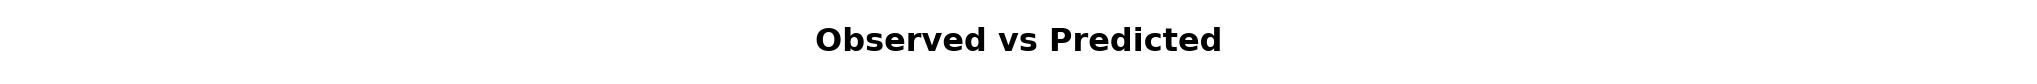

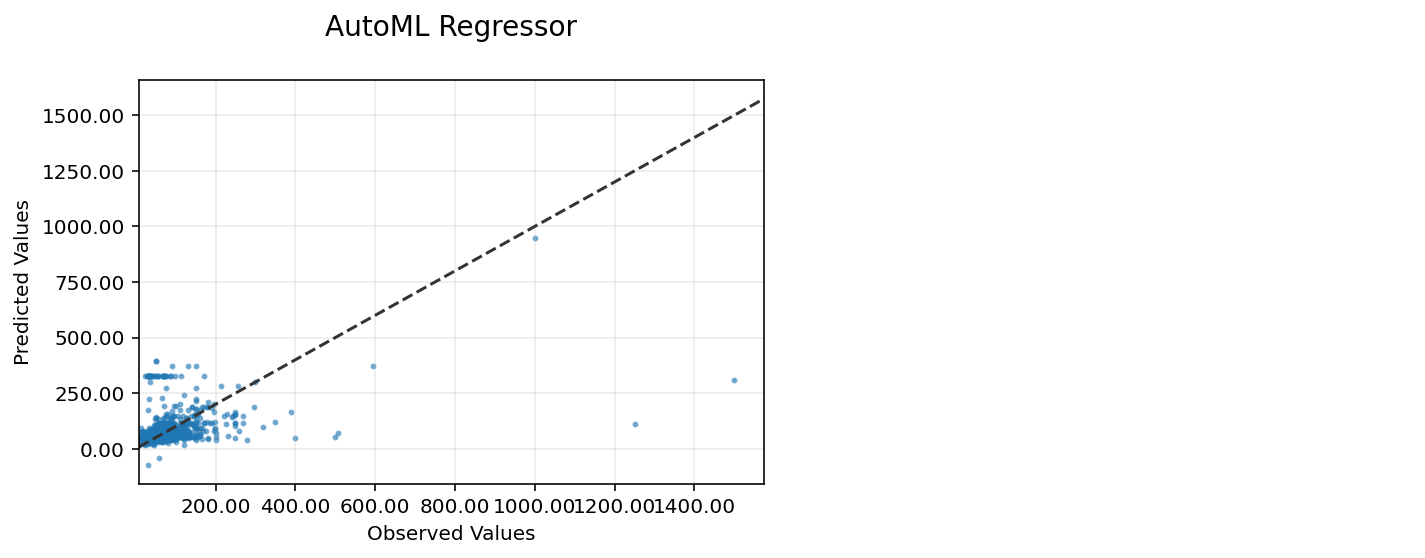

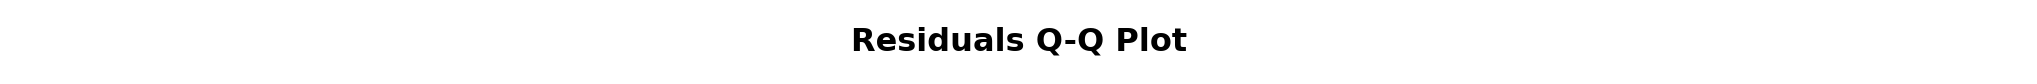

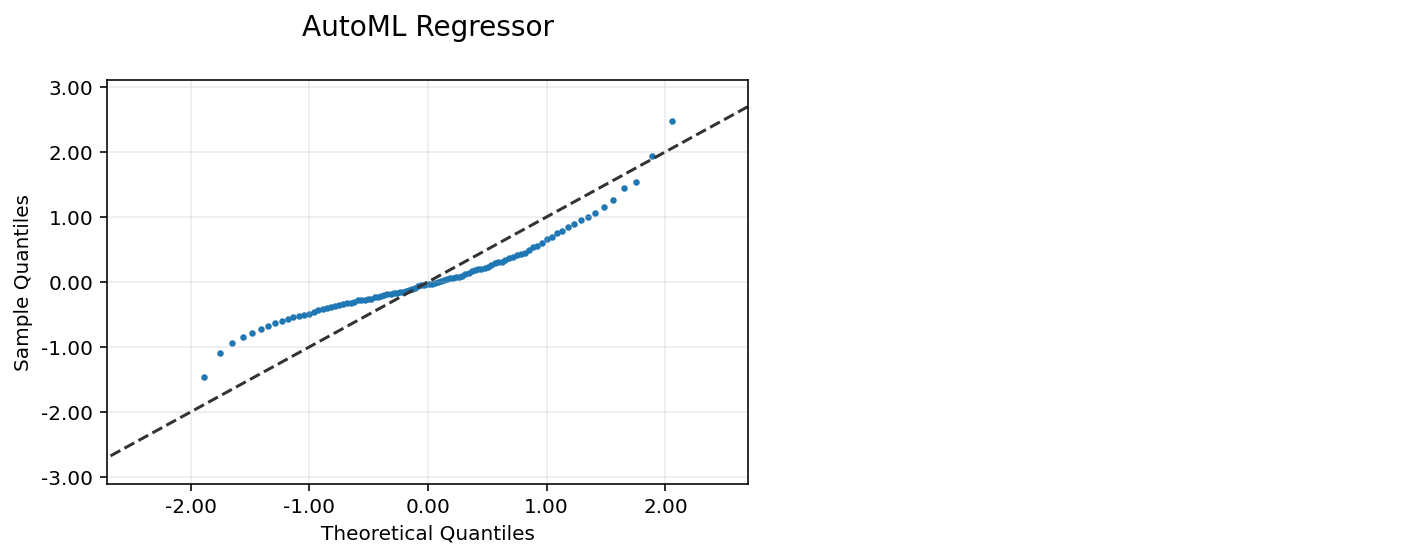

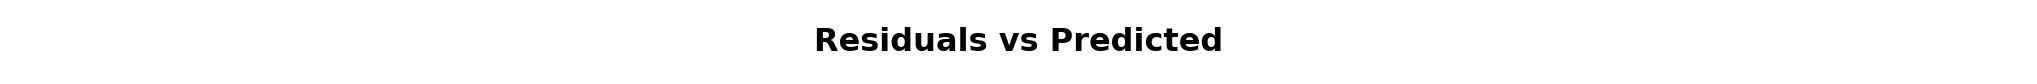

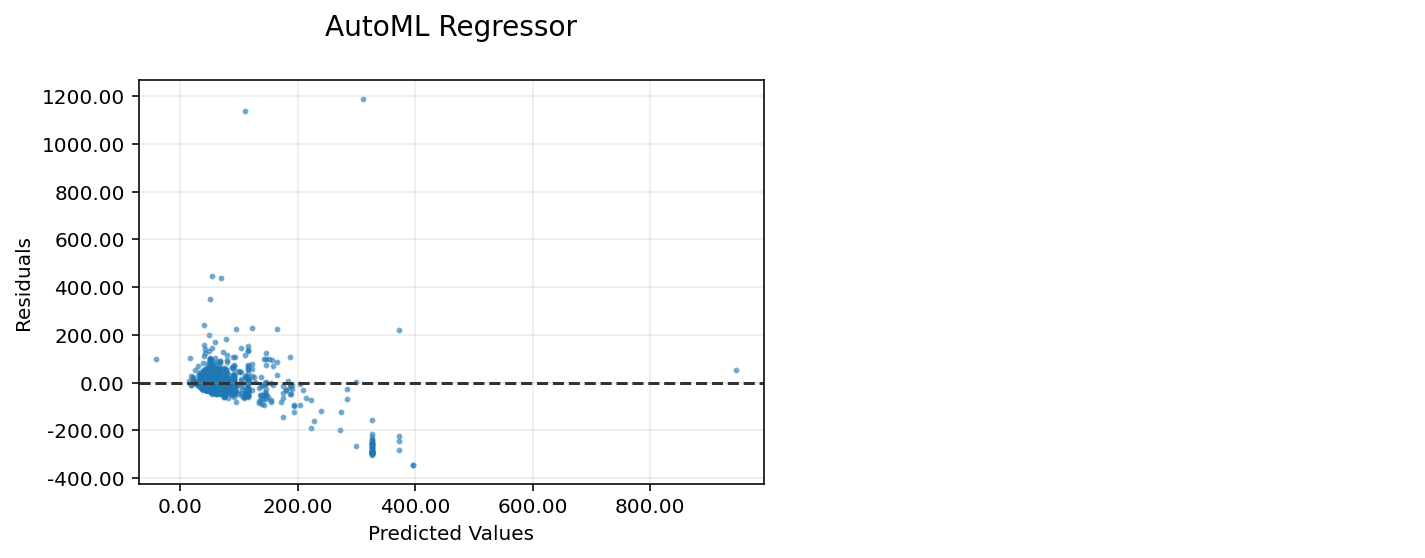

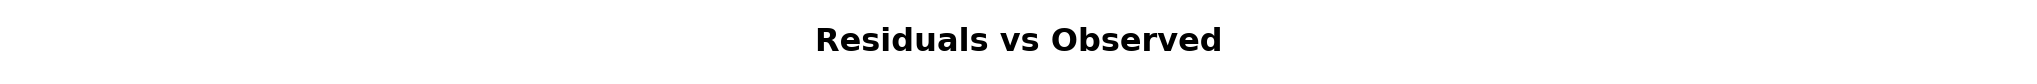

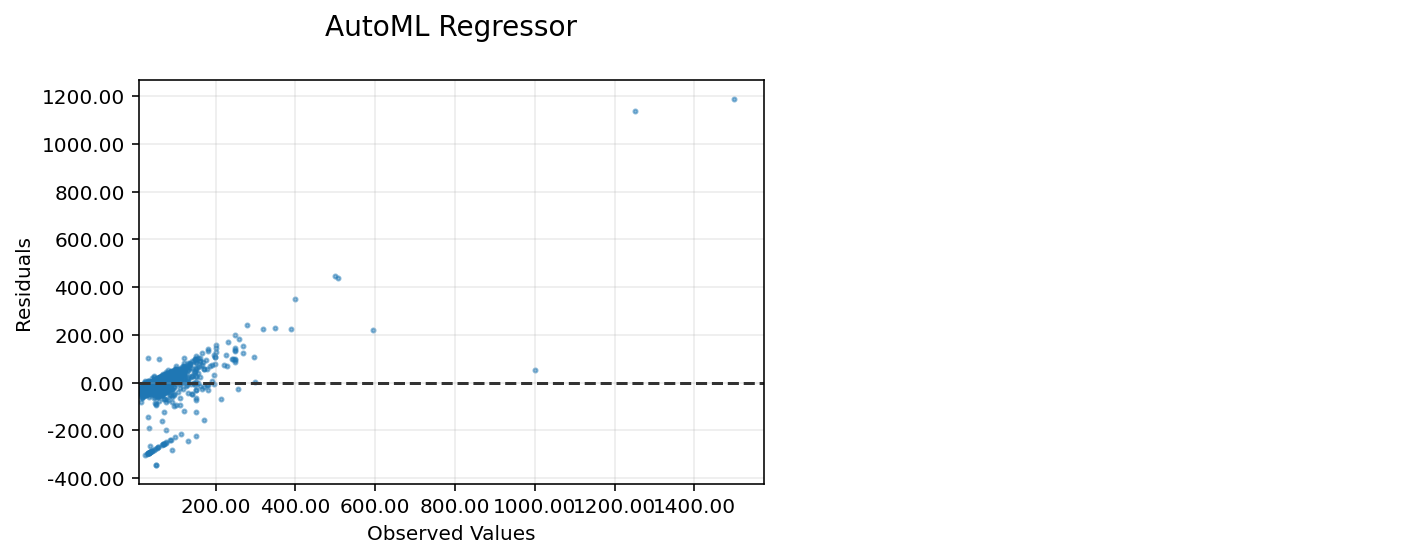

In [22]:
#plot the model evaluating
from ads.evaluations.evaluator import ADSEvaluator
evaluator = ADSEvaluator(val, models=[model], training_data=train)

evaluator.show_in_notebook()

In [23]:
#prepare a directory to store the model artifact
artifact_dir =  os.path.join(os.environ['PWD'], "modelo_serializado")
print(f"Model artifact director: {artifact_dir}")
automl_model = AutoMLModel(estimator=model, artifact_dir=artifact_dir)

Model artifact director: /home/datascience/USP - Palestra Big Data/modelo_serializado


In [44]:
#genarate the model artifact
conda_env = 'generalml_p37_cpu_v1'

automl_model.prepare(inference_conda_env=conda_env,
                     training_conda_env=conda_env,
                     use_case_type='regression',
                     X_sample=train.X,
                     y_sample=train.y,
                     force_overwrite = True)

In [45]:
automl_model.metadata_taxonomy['Hyperparameters'].value =json.dumps(str(model.summary).split('Model Parameters:', 1)[1].split('\n')[0][1:])

In [46]:
#display model taxonomy
automl_model.metadata_taxonomy.to_dataframe()

,Key,Value
0,Algorithm,ensemble
1,ArtifactTestResults,"{'score_py': {'key': 'score_py', 'category': 'Mandatory Files Check', 'description': 'Check that the file ""score.py"" exists and is in the top level directory of the artifact directory', 'error_msg': 'The file 'score.py' is missing.', 'success': True}, 'runtime_yaml': {'category': 'Mandatory Files Check', 'description': 'Check that the file ""runtime.yaml"" exists and is in the top level directory of the artifact directory', 'error_msg': 'The file 'runtime.yaml' is missing.', 'success': True}, 'score_syntax': {'category': 'score.py', 'description': 'Check for Python syntax errors', 'error_msg': 'There is Syntax error in score.py: ', 'success': True}, 'score_load_model': {'category': 'score.py', 'description': 'Check that load_model() is defined', 'error_msg': 'Function load_model is not present in score.py.', 'success': True}, 'score_predict': {'category': 'score.py', 'description': 'Check that predict() is defined', 'error_msg': 'Function predict is not present in score.py.', 'success': True}, 'score_predict_data': {'category': 'score.py', 'description': 'Check that the only required argument for predict() is named ""data""', 'error_msg': 'The predict function in score.py must have a formal argument named 'data'.', 'success': True}, 'score_predict_arg': {'category': 'score.py', 'description': 'Check that all other arguments in predict() are optional and have default values', 'error_msg': 'All formal arguments in the predict function must have default values, except that 'data' argument.', 'success': True}, 'runtime_version': {'category': 'runtime.yaml', 'description': 'Check that field MODEL_ARTIFACT_VERSION is set to 3.0', 'error_msg': 'In runtime.yaml, the key MODEL_ARTIFACT_VERSION must be set to 3.0.', 'success': True}, 'runtime_env_python': {'category': 'conda_env', 'description': 'Check that field MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION is set to a value of 3.6 or higher', 'error_msg': 'In runtime.yaml, the key MODEL_DEPLOYMENT.INFERENCE_PYTHON_VERSION must be set to a value of 3.6 or higher.', 'success': True, 'value': '3.7'}, 'runtime_env_path': {'category': 'conda_env', 'description': 'Check that field MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is set', 'error_msg': 'In runtime.yaml, the key MODEL_DEPLOYMENT.INFERENCE_ENV_PATH must have a value.', 'success': True, 'value': 'oci://service-conda-packs@id19sfcrra6z/service_pack/cpu/General_Machine_Learning_for_CPUs_on_Python_3.7/1.0/generalml_p37_cpu_v1'}, 'runtime_path_exist': {'category': 'conda_env', 'description': 'Check that the file path in MODEL_DEPLOYMENT.INFERENCE_ENV_PATH is correct.', 'error_msg': 'In runtime.yaml, the key MODEL_DEPLOYMENT.INFERENCE_ENV_PATH does not exist.', 'success': True}}"
2,Framework,oracle_automl
3,FrameworkVersion,1.0
4,Hyperparameters,"""{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.22866159632554225, 'max_delta_step': 0, 'max_depth': 7, 'min_child_weight': 0, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 276, 'n_jobs': 1, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 0.01778279410038923, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}"""
5,UseCaseType,regression


In [47]:
#display the model status list
automl_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Available     Local tested .predict from score.py                               
save()    Available     Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Not Available Deployed the model                                                
predict() Not Available Called deployment predict endpoint

In [48]:
#verify the model prediction
automl_model.verify(val.X[0:5])

INFO:xengine:All work stopped
INFO:xengine:All work stopped
Start loading model.pkl from model directory /home/datascience/USP - Palestra Big Data/modelo_serializado ...
Model is successfully loaded.


{'prediction': [54.15947723388672,
  67.16131591796875,
  39.14352035522461,
  50.0731201171875,
  180.56068420410156]}

In [49]:
#save the model to the Model Catalog
model_id = automl_model.save(display_name='Predict Berlim Accommadation Price')

INFO:xengine:All work stopped
INFO:xengine:All work stopped
Start loading model.pkl from model directory /home/datascience/USP - Palestra Big Data/modelo_serializado ...
Model is successfully loaded.
['input_schema.json', 'model.pkl', 'output_schema.json', 'score.py', 'test_json_output.json', 'runtime.yaml']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_4aed9ff5-615b-402b-b197-8f709d314fd8.zip


In [50]:
#create a log group to receive the model deployment logs
from ads.common.oci_logging import OCILogGroup

# Generate a random log group and log name
log_group_name = "ModelDeployment-Demo-" + str(uuid.uuid4())
access_log_name = "ModelDeployment-Demo-Access_Log-" + str(uuid.uuid4())
predict_log_name = "ModelDeployment-Demo-Predict_Log-" + str(uuid.uuid4())

# Create a log group
log_group = OCILogGroup(display_name=log_group_name).create()
log_group_ocid = log_group.id
print(f"Log group OCID: {log_group_ocid}")

# Create an access log in the log group
access_log = log_group.create_log(access_log_name)
access_log_ocid = access_log.id
print(f"Access log OCID: {access_log_ocid}")

# Create a predict log in the log group
predict_log = log_group.create_log(predict_log_name)
predict_log_ocid = predict_log.id
print(f"Predict log OCID: {predict_log_ocid}")

Log group OCID: ocid1.loggroup.oc1.sa-saopaulo-1.amaaaaaatsbrckqa4xfe4cbzckomewce7mljogmlcp6d4uzzmi2mgqriocnq
Access log OCID: ocid1.log.oc1.sa-saopaulo-1.amaaaaaatsbrckqapdjpadsv77nm5yynlfozyzv7r3vvt5fo22lalutoojda
Predict log OCID: ocid1.log.oc1.sa-saopaulo-1.amaaaaaatsbrckqa4h4ftgpommc4kexbsecqcziuionghe3q7bfrzyhrfyfa


In [53]:
%%time
#initialize ModelDeploymentProperties
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ['PROJECT_OCID']
model_deployment_properties = ModelDeploymentProperties(
    model_id
).with_prop(
    'display_name', "Model Deployment Demo using ADS Predicting Berlim Accommodation Prices"
).with_prop(
    "project_id", project_id
).with_prop(
    "compartment_id", compartment_id
).with_logging_configuration(
    log_group_ocid, access_log_ocid, log_group_ocid, predict_log_ocid
).with_instance_configuration(
    config={"INSTANCE_SHAPE":"VM.Standard2.1", "INSTANCE_COUNT":"1",'bandwidth_mbps':10}
)

#deploy the model
deployer = ModelDeployer()
deployment = deployer.deploy(
    model_deployment_properties,
    max_wait_time = 2700
)

deployment_id = deployment.model_deployment_id
print(f"Deployment {deployment_id} is {deployment.state.name}")

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

Deployment ocid1.datasciencemodeldeployment.oc1.sa-saopaulo-1.amaaaaaatsbrckqabzigbg6tkj4fyv2wojy343peyrxbu2enfxel3swcukaa is ACTIVE
CPU times: user 2.09 s, sys: 276 ms, total: 2.37 s
Wall time: 16min 15s


In [56]:
#test the model deployment
deployment.predict(test.X[24:25].to_json())

{'prediction': [63.05718231201172]}

In [57]:
test.y[24:25]

16330    50
Name: price, dtype: int64